# Empirical Information Bottleneck Test
## Alex Filipowicz, Eugenio Piasini, Jon Levine

The goal of this notebook is to put some context to the questions we're interested in asking about the type of information people use to approach decision-making tasks, and how effectively they use the inforamtion they encode.

The first few section are the motivation and some previous methods, and section 4 onwards are our attempts to generalize this to different tasks.

### 0) Motivation

The goal of this notebook is to get a solid measure of predictive information and apply it to the triangles task. This will serve as a validation for its use on other tasks, such as the model-based/model-free Daw two step task.

### 1) Load data

The data I'm loading below are from model simulations doing the triangles task. The simulations run through a predictive version of the triangles task (i.e., the models are trying to predict the triangle that will generate the next tone). For now we'll consider two models:

- 1) Model with a wide prior over hazard rate ('Post2'): This model tries to infer the hazard rate in the task using a wide prior over the hazard rate space. This makes it very adaptable to changes in hazard rate, but more variable in its decisions.

- 2) Model with narrow prior ('Poste7'): This model explores a restricted range of hazard rates, using behavior that essentially amounts to following the evidence.

Data is loaded below and behavioral plots are added to show what their performance look like.

In [5]:
%pylab
%matplotlib inline
import sys, csv
sys.path.append('./embo')
sys.path.append('./predinfo')
from embo.embo import empirical_bottleneck as eb
from predinfo import predinfo as pi
import embo.utils
import pandas as pd
import numpy as np
from numba import jit
from scipy import stats
from scipy.stats import spearmanr, entropy
%config InlineBackend.figure_format = 'svg'

from IPython.core.debugger import Pdb

# import jtplot submodule from jupyterthemes
from jupyterthemes import jtplot

# currently installed theme will be used to
# set plot style if no arguments provided
jtplot.style()

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


/Users/alsfilip/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['pi']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


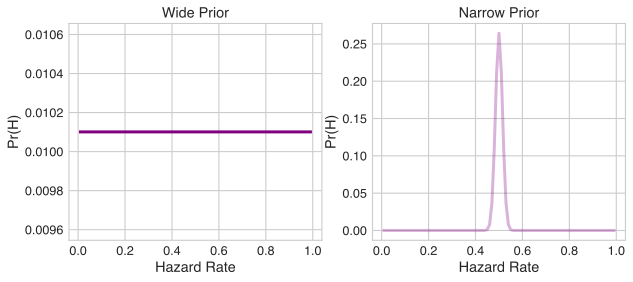

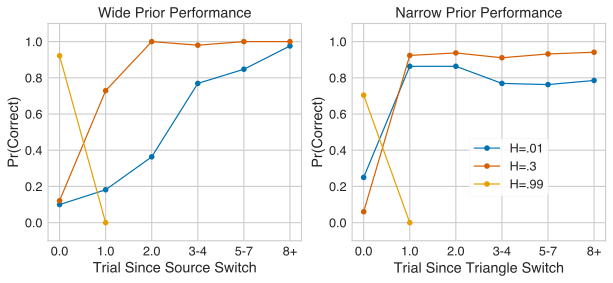

In [6]:
# Read in trial sequences
#path = '/Users/alsfilip/Dropbox/Penn/Auditory_2AFC/Auditory_2AFC/Merged_Data/'
d1 = pd.read_csv('./data/Auditory_2AFC/Normative_Entropy.csv',sep=',')

# Here z corresponds to the triangle on each trial that generated the star (x) on each trial
# Convert triangles to 0s and 1s
d1['z'] = d1['z']-1

# Get LLR - used to compute model prior odds of choosing 0 or 1
llr = np.zeros((3000,1))
llr[d1['x'] == 0] = log(.2)-log(.8)
llr[d1['x'] == 1] = log(.8)-log(.2)
d1['LLR'] = llr

# Load in model simulations
d2 = pd.read_csv('./data/Auditory_2AFC/ModelSim.csv',sep=',')

# Get log prior odds that the model would have guessed the trianlge on the current trial (before seeing a star)
#Stupid fix to make it so that a probability of 1 corresponds to the probability of making a right side choice
d2['Post2'] = 1-d2['Post2']   #Wide model
d2['Poste7'] = 1-d2['Poste7'] #Narrow model

# Get prior probability p(X|Z == 1) - which is the posterior odds minus the evidence (LLR)
d2['p2_Prior_LO'] = (np.log(d2['Post2'])-np.log(1-d2['Post2'])) - d1['LLR']
d2['pe7_Prior_LO'] = (np.log(d2['Poste7'])-np.log(1-d2['Poste7'])) - d1['LLR']

#Convert odds to probabilities
d2['p2_Prior_Prob'] = 1./(1+np.exp(-d2['p2_Prior_LO']))
d2['pe7_Prior_Prob'] = 1./(1+np.exp(-d2['pe7_Prior_LO']))

#Hardmax response policy (i.e., always respond 'right' if your prob is above .5)
d2['p2_Resp'] = np.array(d2['p2_Prior_Prob']>.5).astype(float)
d2['pe7_Resp'] = np.array(d2['pe7_Prior_Prob']>.5).astype(float)


# Create new data from with stim and model responses
d = pd.DataFrame()
d['Session'] = np.zeros(3000)
d['Session'][d1['Var1'] < 1001] = 1
d['Session'][(d1['Var1'] > 1000) & (d1['Var1'] < 2001)] = 2
d['Session'][d1['Var1'] > 2000] = 3
d['H'] = d1['h']
d['Z'] = d1['z']
d['X'] = d1['x']
d['LLR'] = d1['LLR']
d['Wide_Prob'] = d2['p2_Prior_Prob']
d['Narrow_Prob'] = d2['pe7_Prior_Prob']
d['Wide_Resp'] = d2['p2_Resp']
d['Narrow_Resp'] = d2['pe7_Resp']
d['Wide_Correct'] = np.array(d['Wide_Resp'] == d['Z']).astype(float)
d['Narrow_Correct'] = np.array(d['Narrow_Resp'] == d['Z']).astype(float)

# Add changepoint and trial since changepoint information - for plotting
cp = np.zeros((3000,1))
tscp = np.zeros((3000,1))
curr_tscp = 0
for i in range(len(d['X'])):
    if i > 0:
        cp[i] = d['Z'][i] != d['Z'][i-1]
        if cp[i] == 1:
            curr_tscp = 0
        else:
            curr_tscp += 1
    tscp[i] = curr_tscp
d['cp'] = cp
d['tscp'] = tscp
tscp2 = np.array(tscp).astype(str)
tscp2[(tscp > 2) & (tscp < 5)] = '3-4'
tscp2[(tscp > 4) & (tscp < 8)] = '5-7'
tscp2[tscp > 7] = '8+'
d['tscp2'] = tscp2

# Show the prior space of each model
hspace = np.arange(.01,1,.01)
wide = stats.beta.pdf(hspace,2*.5,2*(1-.5))
wide = wide/sum(wide)
narrow = stats.beta.pdf(hspace,np.exp(7)*.5,np.exp(7)*(1-.5))
narrow = narrow/sum(narrow)

h1_col = "#0072B2"
h3_col = "#D55E00"
h9_col = "#E69F00"

figure(1,(10,4))
subplot(1,2,1)
plot(hspace,wide,'-',color='purple',lw=3)
ylabel('Pr(H)')
xlabel('Hazard Rate')
title('Wide Prior')
subplot(1,2,2)
plot(hspace,narrow,'-',color='purple',alpha = .3,lw=3)
ylabel('Pr(H)')
xlabel('Hazard Rate')
title('Narrow Prior')

figure(2,(10,4))
subplot(1,2,1)
plot(d[d['H']==.01].groupby('tscp2')['Wide_Correct'].mean(),'-o',label='H=.01',color = h1_col)
plot(d[d['H']==.3].groupby('tscp2')['Wide_Correct'].mean(),'-o',label='H=.3',color=h3_col)
plot(d[d['H']==.99].groupby('tscp2')['Wide_Correct'].mean(),'-o',label='H=.99',color=h9_col)
ylim([-.1,1.1])
title('Wide Prior Performance')
xlabel('Trial Since Source Switch')
ylabel('Pr(Correct)')

subplot(1,2,2)
plot(d[d['H']==.01].groupby('tscp2')['Narrow_Correct'].mean(),'-o',label='H=.01',color = h1_col)
plot(d[d['H']==.3].groupby('tscp2')['Narrow_Correct'].mean(),'-o',label='H=.3',color=h3_col)
plot(d[d['H']==.99].groupby('tscp2')['Narrow_Correct'].mean(),'-o',label='H=.99',color=h9_col)
ylim([-.1,1.1])
title('Narrow Prior Performance')
xlabel('Trial Since Triangle Switch')
ylabel('Pr(Correct)')
legend(bbox_to_anchor=(.8,.5))

### 2) Computing predictive information and the information bottleneck

#### 2.1) Predictive information

The first step will be to reproduce some of our previous analyses. The previous analyses sought to measure how much past stimulus information a person was encoding from past task features - this information essentially provides a principled measure of the person's mental model "complexity", a good proxy for the "cognitive effort" a person is putting into the task.  

This encoding was done by measuring the mutual information between past stimulus features $F_{past}$ and participant responses $R_{now}$. We previously defined task features (Glaze et al., 2018) as combinations of the hazard rate on each trial $H_t$ and stars $X_t$ for any trial $t$.

To capture the amount of information participants were encoding about the hazard rate, we computed the mutual information between some past stimulus feature, and a window of subject responses $R_{0-n}$, where $0$ indicates the current trial, and $n$ indicates some window into the future.

For the predictive task, I set this window to 2 (in glaze et al. the window was set to 3, but we also had more data per subject - doesn't make much difference either way).

So $I_{past}$ is calculated as:

$$ I(F_{-1};R_{0-n}) = \sum_f \sum_r p(f,r)\log_2\Bigg [ \frac{p(f,r)}{p(f)p(r)}\Bigg]$$

The extent to which subject responses are predicting the future (i.e., $I_{future}$) is meaured similarly as

$$ I(R_{0-n};F_{n+1}) = \sum_r \sum_f p(r,f)\log_2\Bigg [ \frac{p(r,f)}{p(r)p(f)}\Bigg] $$

These quantiies tell us a) how much of the hazard/stimulus features subjects are encoding ($I_{past}$), and how effectively they are using this information to predict the future ($I_{future}$). The next step is calculating how effectively subjects are using the amount of information they are encoding from the task to predict the future. This is done using the information bottleneck.

The math here gets a little hairy, but the information bottleneck manages to take a stream of data and tell you for any amount of that data stream you want to compress. So enssentially, it's telling you for any amount of $I_{past}$ you want to compress, what's the best $I_{future}$ you can hope to acheive. This is interesting because it demonstrates that rather than have *one* optimal model for a task, there are actually *many* optimal models depending on the amount of information you are willing to encode from the task. The following section covers a method we can use to compute these optimal models.

#### 2.2) The Information Bottleneck

The goal here is to represent a mental model $M$ as a compression of task features $F = \{f_1,f_2,...,f_n\}$. The optimal compression of $F$ is one which provides the most preictive information about future observations $Y$. The predictive information contained within a sequence can be measured by the mutual information between past and future observations, or $I_{pred}\equiv I(F;Y)$. Therefore, the optimal compression $M$ is one which minimizes the information retained from the past $I_{past}\equiv I(F;M)$, while maximizing the preditcive information about the future $I_{future}\equiv I(M;Y)$.

The information bottleneck (Tishby, Pereira, Bialek, 2000) provides a method to obtain this optimal compression. It can be obtained by solving the following equation:
$$L[p(M|F)]=I(F;M)-\beta I(M;Y)$$

where $L[p(M|X)]$ indicates the quatitity to be minimized, and $\beta$ is a Lagrange multiplier. If we solve this equation for a range of values of $\beta$, we obtain an information bottleneck curve, which indicates the best compression possible for different sizes of $I_{past}$. When $\beta \rightarrow 0$, none of the past is retained and therefore the compression has no predictive power. Conversely, $\beta \rightarrow \infty$ implies that all of the past is being retained (i.e., no compression), and the curve saturates at $I(F;Y)$.

Typically, the equations above are hard to solve. However, Tishby and colleagues prove that the solution can be obtained using the Blahut-Arimoto algorithm. For a source $X$, this algorithm converges on an optimal compression $\hat{X}$ that minimizes the source's distortion $d(X,\hat{X})$ using the joint distribution $p(X,\hat{X})$. It is implemented by iterating between these two equations until convergence:

$$p_{t+1}(\hat{X})=\sum_{x \in X}{p_t(x)p_t(\hat{x}|x)}$$

$$p_{t+1}(\hat{X}|X)=\frac{p_t(\hat{x})\exp(-\beta d_t(x,\hat{X}))}{\sum_{\hat{x} \in \hat{X}}{p_t(\hat{x})\exp(-\beta d_t(x,\hat{x}))}}$$

where $\beta$ indicates the targeted slope in the rate distortion curve (i.e., the amount of distortion we are willing to accept in our signal).

In the context of the information bottleneck, $\beta$ has a similar function, indcating the amount of the past we're aiming to keep. Tishby and colleagues demonstrate that the distortion $d(x,\hat{x})$ is equivalent to $D_{KL}[p(Y|X)\| p(Y|\hat{X})]$, where $D_{KL}$ is the KL divergence. Therefore, in order to obtain the minimum $p(M|F)$ that maximizes $I(M;Y)$ for a given value $\beta$, we can iterate through the following equations

$$p(M|F) = \frac{p(M)}{Z(F,\beta)}\exp\Big[-\beta\sum_{y \in Y}{p(y|F)\log\frac{p(y|F)}{p(y|F)}}\Big]$$

where $Z(X,\beta)$ represents the normalizing factor $Z(X,\beta) = \sum_{m \in M}{p(m) \exp \Big[\sum_{y \in Y}{p(y|f) \log \frac{p(y|f)}{p(y|m)}}\Big]}$, and

$$p(Y|M) = \frac{1}{p(m)} \sum_{f \in F}{p(y|f)p(m|f)p(f)}$$

to ensure the markovian relation $M \leftarrow X \leftarrow Y$ between past, compression and future, and 

$$p(M) = \sum_{f \in F}{p(m|f)p(f)}$$

Iterating through these three equations provides a distribution $p(M|X)$ for a given value of $\beta$ that minimizes $I_{past}$, while maximizing $I_{future}$.

#### 2.3) Calculating the Information Bottleck for a given task

So in our case, we have two goals:

- 1) Calculate and inforamtion bottleneck for a particular task

- 2) Show how people compare to this EIB by seeing how well they're doing with the amount of information they're encoding from the task.

The analytic solution for the Information Bottleneck is only available for a limited number of cases. However, it can be computed numerically to generate an "empirical" information bottleneck (EIB), one that is calculated for a set of data. Eugenio and I developped a (less than alpha) library (embo) that uses the algorithm above and computes an EIB for any sequence it is given.

Below I apply embo and its functions to compute the EIB for the task I loaded up earlier. Here we're defining features the same way as we did before (i.e., combinations of hazard rate and observed star position on each trial). We will then compute the EIB between a feature from the past $F_{past}$ and a feature in the future $F_{future}$. In this task, the stars either occured on the left or the right (take a value of 0 or 1 respectively), and there were three hazard rates ($H \in \{.01,.3,.99\}$). Therefore, for this task, there are 6 possible features.

So the bottleneck I'm trying to solve is

$$ L[p(M|F_{past})]=I(F_{past};M)-\beta I(M;F_{future})$$

and the curve emerges by considering a bunch of different values of $\beta$ (remember, higher values correspond to more of the past being compressed).

The code below defines the hazerd/stimulus features for the current task.

In [3]:
# Define task features
d['F'] = np.zeros((3000,1))
d['F'][(d['H'] == .01) & (d['X'] == 0)] = 0
d['F'][(d['H'] == .01) & (d['X'] == 1)] = 1
d['F'][(d['H'] == .3) & (d['X'] == 0)] = 2
d['F'][(d['H'] == .3) & (d['X'] == 1)] = 3
d['F'][(d['H'] == .99) & (d['X'] == 0)] = 4
d['F'][(d['H'] == .99) & (d['X'] == 1)] = 5

/Users/alsfilip/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/alsfilip/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/alsfilip/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

The function "empirical_bottleneck" (loaded as "eb" above) computes all the different points we need along the $I_{past}$ $I_{future}$ plane. Here the arguments are:

eb(past,future,numbeta= number of increments between 0 and maxbeta, maxbeta = maximum value of beta you want to consider)

The function returns:

- ipast for each values of beta
- ifuture for each value of beta
- values of beta that were considered
- Mutual informtion between past and future
- information contained in past
- inforamtion contained in future

The curve should saturate at the mutual inforamtion between the past and the future, and you can only compress as much as the past as is allowed by the number of symbols you're using to compress the past.

The plots below show what these values look like, and the EIB is the 2D plot if Ipast for each value of beta v Ifuture

In [4]:
# Here we're computing the EIB for:
# what the feature from the last trial (Fpast) tells you about the current trial (Ffuture)
Fpast = np.array(d['F'][0:-1])
Ffuture = np.array(d['F'][1:])

# #Compute the EIB - takes a few minutes to run with 3000 numbeta
# start1 = time.time()
# i_p1,i_f1,beta1,mi1,hx1,hy1 = eb(Fpast,Ffuture,numbeta=2000,maxbeta=50,parallel=False)
# print(time.time()-start1)

start2 = time.time()
i_p2,i_f2,beta2,mi2,hx2,hy2 = eb(Fpast,Ffuture,numbeta=2000,maxbeta=50,parallel=8)
print(time.time()-start2)

34.62982130050659


Text(0, 0.5, '$I_{future}$')

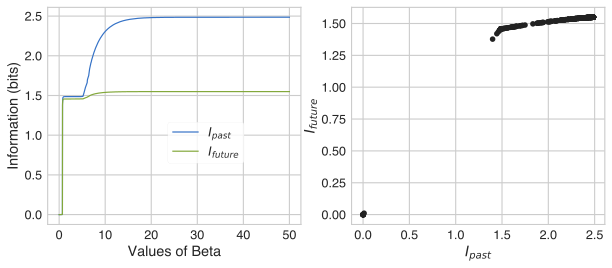

In [5]:
i_p = i_p2
i_f = i_f2
beta = beta2
# Plot both Ipast and Ifuture for different values of beta (Ifuture should always be equal or smaller than Ipast)
figure(2,(10,4))
subplot(1,2,1)
plot(beta,i_p,label='$I_{past}$')
plot(beta,i_f, label = '$I_{future}$')
xlabel('Values of Beta')
ylabel('Information (bits)')
legend(bbox_to_anchor=(.8,.5))

subplot(1,2,2)
plot(i_p,i_f,'ok',label='Epirical Information Bottleneck')
xlabel('$I_{past}$')
ylabel('$I_{future}$')

So now that we have all of these different empirical points for different values of beta, we can approximate the Information Bottleneck curve by taking the convex hull of the different points. The three functions below help calculate a convex hull, which allows us to convert those points into a curve.

In [6]:
# FUNCTIONS TO COMPUTE CONVEX HULL
def split(u, v, points):
    # return points on left side of UV
    return [p for p in points if np.cross(p - u, v - u) < 0]

def extend(u, v, points):
    if not points:
        return []

    # find furthest point W, and split search to WV, UW
    w = min(points, key=lambda p: np.cross(p - u, v - u))
    p1, p2 = split(w, v, points), split(u, w, points)
    return extend(w, v, p1) + [w] + extend(u, w, p2)

def convex_hull(points):
    # find two hull points, U, V, and split to left and right search
    u = min(points, key=lambda p: p[0])
    v = max(points, key=lambda p: p[0])
    left, right = split(u, v, points), split(v, u, points)

    # find convex hull on each side
    return [v] + extend(u, v, left) + [u] + extend(v, u, right) + [v]

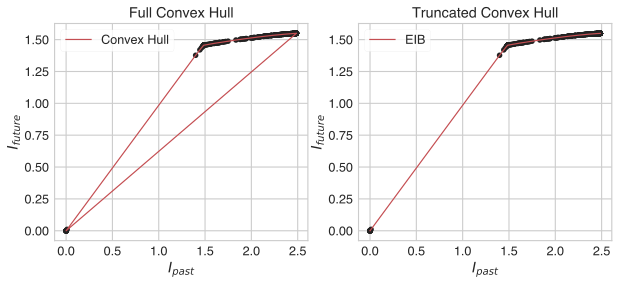

In [7]:
# Compute the convex hull for the i_p and i_f points we're found above
points = np.stack([i_p,i_f],axis=1)
hull = np.array(convex_hull(points))

#Plot the points and the hull
figure(3,(10,4))
subplot(1,2,1)
plot(i_p,i_f,'ok')
plot(hull[:,0],hull[:,1],'-r',label='Convex Hull')
xlabel('$I_{past}$')
ylabel('$I_{future}$')
title('Full Convex Hull')
legend()

subplot(1,2,2)
plot(i_p,i_f,'ok')
plot(hull[0:-1,0],hull[0:-1,1],'-r',label='EIB')
xlabel('$I_{past}$')
ylabel('$I_{future}$')
title('Truncated Convex Hull')
legend()

So this is how we get the empirical bottleneck. You just need to specify you're array of past observations and future observations. Next we calculate the predictive information fo each subject and see how far they fall from the bound.

Lets do this for the two example subjects we loaded in earlier (Wide and Narrow that are part of 'd'). For this I am reproducing the predictive information function we created below. Remember that in this case, I want a vector of hazard/stim features, and windows of responses (in the case below, two trials). I'm using the helper functions we wrote to accomplish this.

There's a bit of a complication to clarify with what we did previously. In this case, our interest in in capturing the amount of information a subject in encoding about the task, beyond the information that is contained in the stimuli themselves. So for this predictive version fo the task, for $I_{past}$, we compute the mutual inforamtion between the feature on trial $n$ ($f_n$) and the window of responses $[R_{n+2},R_{n+3}]$. Similarly, $I_{future}$ is computed as the mutual inforamtion between $[r_{n},r_{n+1}]$ and $f_{n+2}$ (we can chat about why this is).

The original "predinfo" function (loaded as "pi" above) is what I originally used to compute these quantities. The function takes the following arguments:

- Vector of responses
- Vector of features
- Size of the window of responses to be considered
- Size of the widow of features to be considered
- number of symbols in the responses
- number of symbols in the features

The function returns the $I_{past}$ and $I_{future}$ for each subject. Lets do this below - we have our EIB curve above, and lets now plot the predictive inforamtion from our two subjects along this curve.

In [8]:
# Plot wide and narrow performance in IB space
wide = d['Wide_Resp']
narrow = d['Narrow_Resp']
feat = d['F']

# Compute the predictive inforamtion for each simulated subject
# Note that the subselecting is to offset the fact that this is a predictive task (not ideal but how it was implemented before)
ip_w,if_w = pi(wide[1:],feat[0:-1],2,1,2,6)
ip_n,if_n = pi(narrow[1:],feat[0:-1],2,1,2,6)

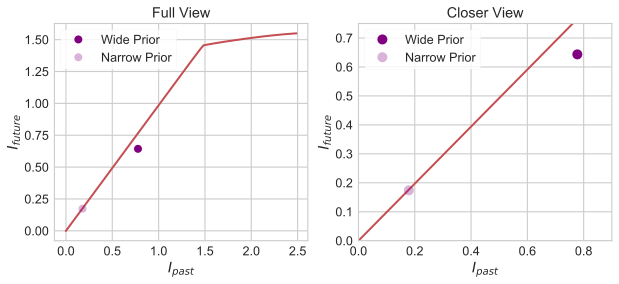

In [9]:
figure(4,(10,4))
subplot(1,2,1)
plot(hull[0:len(hull[:,0])-1,0],hull[0:len(hull[:,1])-1,1],'-r',lw=2)
plot(ip_w,if_w,'o',color='purple',markersize=8,label='Wide Prior')
plot(ip_n,if_n,'o',color='purple',markersize=8,alpha = .3,label='Narrow Prior')
ylabel('$I_{future}$')
xlabel('$I_{past}$')
title('Full View')
legend()

subplot(1,2,2)
plot(hull[0:-1,0],hull[0:-1,1],'-r',lw=2)
plot(ip_w,if_w,'o',color='purple',markersize=10,label='Wide Prior')
plot(ip_n,if_n,'o',color='purple',markersize=10,alpha = .3,label='Narrow Prior')
ylabel('$I_{future}$')
xlabel('$I_{past}$')
title('Closer View')
ylim(0,.75)
xlim(0,.9)
legend()

There are a couple of things to notice here. First, subjects with a narrower prior over hazard rate have lower $I_{past}$. This is consistent with Glaze et al., 2018, where subjects encoding less of the hazard-rate information were best fit by a model with a narrow prior. Note also that this subject has a low $I_{future}$, which makes sense: given that you're only encoding a little of the past, there's only so much you can say about the future.

But interestingly, the second observation is that the model using a wider prior seems to fall farther from the optimal bound than the model with a narrower prior. This essentially shows that while subjects with a wider prior are encoding more inforamtion about the task, they aren't using this inforamtion as effectively as they could be.

The code below computes and plots a 'distance from the bound'.

This proposes an interesting hypothesis: subjects with more compelx mental models encode more inforamtion about the environment, but use this information less efficiently. Subjects with simpler models engage less with the task, but use the inforamtion they choose to encode more optimally.

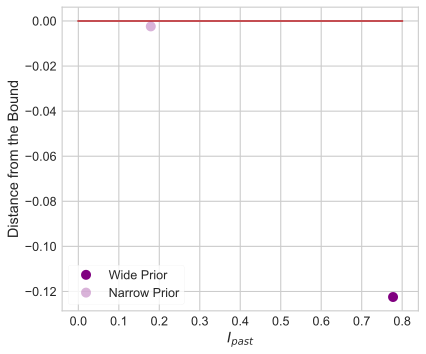

In [10]:
# Get distance from bound
# Function to get distance from the bound for any value of ipast
def deltaBound(ib_ipast,ib_ifuture,p_ipast,p_ifuture):
    ''' Function to calculate distance from the bound between an empirical IB and participant predictive info
    ib_ipast: ipast of empirical IB (x of convex hull)
    ib_ifuture: ifuture of empirical IB (y of convex hull)
    p_ipast: participant ipast (uncorrected)
    p_ifuture: participant ifuture (uncorrected)
    
    Returns participant ifuture minus the empirical bound (more negative = farther away from the bound)
    '''
    ind = np.argwhere(np.array(ib_ipast) > p_ipast)[0][0]
    slp = (ib_ifuture[ind]-ib_ifuture[ind-1])/(ib_ipast[ind]-ib_ipast[ind-1])
    intercept = ib_ifuture[ind]-(slp*ib_ipast[ind])
    #Return distance between participant Ifuture and interpolated bound - higher 
    return p_ifuture - ((p_ipast*slp)+intercept)

plot([0,.8],[0,0],'-r',lw=2)
plot(ip_w,deltaBound(np.flip(hull[0:-1,0],0),np.flip(hull[0:-1,1],0),ip_w,if_w),'o',markersize=10,color='purple',label='Wide Prior')
plot(ip_n,deltaBound(np.flip(hull[0:-1,0],0),np.flip(hull[0:-1,1],0),ip_n,if_n),'o',markersize=10,color='purple',alpha=.3,label='Narrow Prior')
ylabel('Distance from the Bound')
xlabel('$I_{past}$')
legend()

### 3) Applying this to data

So we have a hypothesis: subjects with more complex models, that is those encoding mroe of the past, should fall farther from the bound.

We have data from this task, so lets apply everything we just did to the subject data. In our case, subjects performed up to three sessions, and any subject that performed a given session say the exact same sequence of stimuli. However, not all subjects performed all sessions, meaning that the exact sequences seen between subjects differed. To overcome this limitation, we will compute an EIB for each possible combination of trials each subject could ahve seen, and compute their distance from the bound from the bound computed from their respective sequence of features.

The code below does this, and plots each subject compared the their respective bounds. The first plot shows each subjects compared to their respective bound. The second plot shows the distance of each subject with respect to their bound.

Similar to the simulations, participants show the same trend of falling farther away from the bound as they encode more about the task.

In [11]:
# Auditory 2afc features
f = d['F']
d13 = d[(d['Session'] ==1) | (d['Session'] == 3)] # Subselect trials in first and third sessions only
f13 = d13['F'] # Session features

#Helper function
def getEIB(features,numbeta=10000,maxbeta=50):
    '''
    Function to calculate empirical bound for a subset of features
    for now, the size of the feature lambda used for the bound calculation is equal to the number of unique features contained within the feature sequence
    
    Input:
    features: array of features obserbved in the experiment
    numbeta: number of beta subdivision for the IB calculation between 0 and maxbeta
    maxbeta: maximum value of beta to be considered
    '''
    
    # For now, size of feature lambda is equal to the number of features present in the sequence
    f_un = np.unique(features)
    for i in range(len(f_un)):
        features[features == f_un[i]] = i
    
    # Calculate empirical bound
    i_p,i_f,beta,mi,hx,hy = eb(features[0:len(features)-1],features[1:len(features)],numbeta=numbeta,maxbeta=maxbeta,parallel = 8)
    return i_p,i_f,beta,mi,hx,hy

# Uncomment below to run and save bounds for each session
# #Compute empirical bounds for every possible session permutation
nb = 1000 #number of betas
mb = 100 #max value of beta
s1_eib = getEIB(f[0:1000],numbeta=nb,maxbeta=mb)     #Session 1
s2_eib = getEIB(f[1000:2000],numbeta=nb,maxbeta=mb)  #Session 2
s3_eib = getEIB(f[2000:3000],numbeta=nb,maxbeta=mb)  #Session 3
s12_eib = getEIB(f[0:2000],numbeta=nb,maxbeta=mb)    #Session 1 and 2
d13 = d[(d['Session'] ==1) | (d['Session'] == 3)] # Subselect trials in first and third sessions only
f13 = d13['F'] # Session features
s13_eib = getEIB(f13,numbeta=nb,maxbeta=mb) #Session 1 and 3
s23_eib = getEIB(f[1000:3000],numbeta=nb,maxbeta=mb) #Session 2 and 3
s123_eib = getEIB(f,numbeta=nb,maxbeta=mb)#All sessions

#Save bounds and make them accessible for plotting
eibs = {"s1":s1_eib,"s2":s2_eib,"s3":s3_eib,"s12":s12_eib,"s13":s13_eib,"s23":s23_eib,"s123":s123_eib}

/Users/alsfilip/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/alsfilip/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:7626: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/Users/alsfilip/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


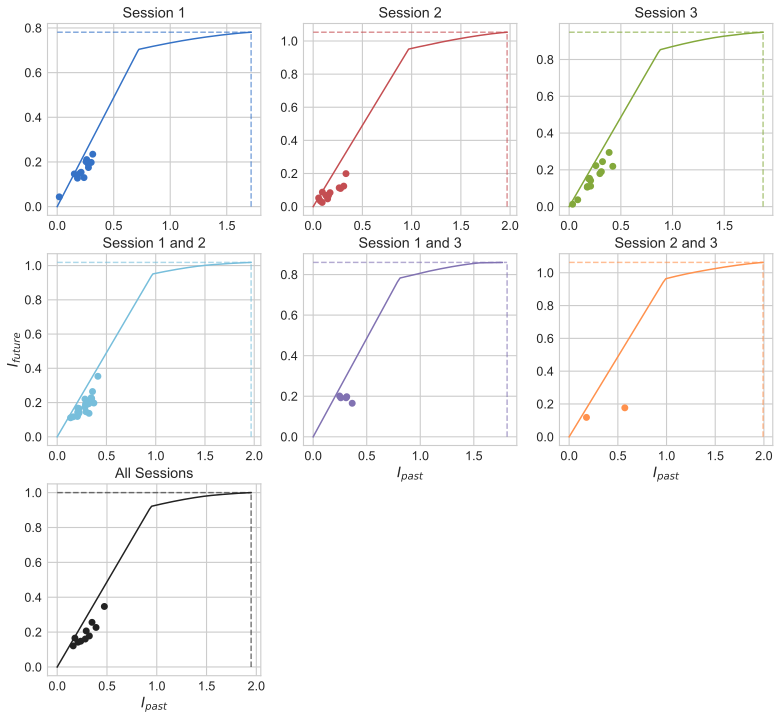

In [17]:
# Get convex hull for each empirical bottleneck
h1 = vstack((eibs['s1'][0],eibs['s1'][1]))
h2 = vstack((eibs['s2'][0],eibs['s2'][1]))
h3 = vstack((eibs['s3'][0],eibs['s3'][1]))
h12 = vstack((eibs['s12'][0],eibs['s12'][1]))
h13 = vstack((eibs['s13'][0],eibs['s13'][1]))
h23 = vstack((eibs['s23'][0],eibs['s23'][1]))
h123 = vstack((eibs['s123'][0],eibs['s123'][1]))

# Load file with participant fits and sessions completed inforamtion - this was computed using the pi function above
subfits = pd.read_csv('./data/Fits2.csv',sep=',')

# Get which sequence participants saw
cors = subfits.iloc[:,9:12]
subfits['SeqID'] = np.array([sum((1!=np.isnan(cors.loc[i]))*np.array([2**0,2**1,2**2])) for i in range(len(subfits['Ipast']))]) #ID of trial sequence participant saw

#Ipast and Ifuture calculated using all 6 features
ipasts = subfits['Ipast']
ifutures = subfits['Ifuture']

# Compute Ipast and Ifuture using number of features participants saw
fs = [f[0:1000],f[1000:2000],f[2000:3000],f[0:2000],f13,f[1000:3000],f]
ipast_n = np.zeros((len(ipasts),1))
ifuture_n = np.zeros((len(ifutures),1))

# Function to plot EIB for a specific sequence and add participant predictive info
def plotEIB(eib,ips,ifs,mi,hx,t,col,trim=1, ylab=True,xlab=True):
    plot([0,hx],[mi,mi],'--'+col,alpha=.6,lw=1.5)
    plot([hx,hx],[0,mi],'--'+col,alpha=.6,lw=1.5)
    plot(eib[0,:],eib[1,:],'-'+col,lw=1.5)
    plot(ips,ifs,'o'+col,markersize=7)
    title(t)
    if ylab == True:
        ylabel('$I_{future}$')
    if xlab == True:
        xlabel('$I_{past}$')
    
#Plot participants according to their respective bounds - also compute ipast and ifuture based on the number of possible features they could have seen
figure(6,(13,12))
cs = ['b','r','g','c','m','y','k']
seqID = [1,2,4,3,5,6,7]
yl = np.array(["1"]*7)
xl = np.array(["1"]*7)
titles = ['Session 1','Session 2','Session 3','Session 1 and 2','Session 1 and 3','Session 2 and 3','All Sessions']
eib = [h1,h2,h3,h12,h13,h23,h123] #Convex hull serving as empirical bound for each session
mis = [eibs['s1'][3],eibs['s2'][3],eibs['s3'][3],eibs['s12'][3],eibs['s13'][3],eibs['s23'][3],eibs['s123'][3]]
hxs = [eibs['s1'][4],eibs['s2'][4],eibs['s3'][4],eibs['s12'][4],eibs['s13'][4],eibs['s23'][4],eibs['s123'][4]]


for i in range(7):
    subplot(3,3,i+1)
    plotEIB(eib[i],ipasts[subfits['SeqID'] == seqID[i]],ifutures[subfits['SeqID'] == seqID[i]],mis[i],hxs[i],titles[i],cs[i],ylab=yl[i],xlab=xl[i])
    if i == 3:
        ylabel('$I_{future}$')
    elif i in [4,5,6]:
        xlabel('$I_{past}$')
    
savefig('/Users/alsfilip//Desktop/DiffBounds.eps')   

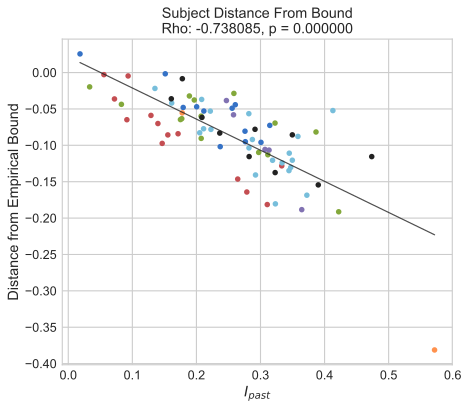

In [18]:
#Plot distance from bound
seqIds = ['s1','s2','s12','s3','s13','s23','s123']
seqNames = []
for i in subfits['SeqID']:
    seqNames.append(seqIds[i-1])

subfits['SeqName'] = seqNames
subs = np.unique(subfits['Subject'])
subIPs = subfits['Ipast']
subIFs = subfits['Ifuture']
dfbs = []
figure(7,(7,6))
for s in range(len(subs)):
    sqID = subfits['SeqID'][s]
    idx = seqID.index(sqID)
    eib = eibs[subfits['SeqName'][s]]
    dfb = deltaBound(eib[0],eib[1],subIPs[s],subIFs[s])
    dfbs.append(dfb)
    plot(subIPs[s],dfb,'o',color=cs[idx])

z = np.polyfit(np.array(subIPs), np.array(dfbs), 1)
p = np.poly1d(z)
plot(subIPs,p(subIPs),'k',alpha = .8)
ylabel('Distance from Empirical Bound')
xlabel('$I_{past}$')
r,p = spearmanr(dfbs,subIPs)
title("Subject Distance From Bound\nRho: %f, p = %f"%(r,p))

savefig('/Users/alsfilip/Desktop/DfB.eps')

### 4) Next Steps

So this framework is interesting, but now we want to apply it more broadly.

Based on our conversations, it sounds like a better formulation for the EIB would be to make it more like the task the subjects are trying to accomplish. For the triangles task, people don't actually have access to the hazard rate, nor are they being asked to estimate it.

A better version may be a version which takes into account the task subjects are trying to accomplish. In this predictive triangles task, subjects are being asked to predict the triangle that will generate the next star. All the subjects have access to are the stars they observe on each trial. Therefore, a better formulation, closer to what the subjects are trying to do, would be see how much of past star positions are going into a subject's mental model, and how effectively they are using that information would be captured by the mutual inforamtion between their responses and the triangles on each trial.

So what we would be computing is:

$$ I_{past} = I(X_{past};R_{now}) = \sum_{x}\sum_{r}p(x,r)\log_2\Bigg[ \frac{p(x,r)}{p(x)p(r)}\Bigg]$$

$$ I_{future} = I(R_{now};T_{now}) =  \sum_{r}\sum_{t}p(r,t)\log_2\Bigg[ \frac{p(r,t)}{p(r)p(t)}\Bigg]$$

The bottleneck would be very similar, but now we'd be trying to figure out how much of $X_{past}$ we need to encode in order to predict $T_{now}$.

$$L[p(M|X_{past}) = I(X_{past};M)-\beta I(M;T_{now})$$

As we discussed, we can use a window of $X_{past}$ of any size, but probably 2-3 should be enough.

So next steps:

- 1) Compute the predictive information and IB using the formulation above.
- 2) See if this same type of formulation can be applied to the Daw two step task

Do we see the same relationships between complexity ($I_{past}$) and distance from the bound?

## NOTES/CODE TO HELP WITH THE ABOVE STEPS

The code below is some fo the progress we made to implement the next steps.

**MAJOR THING TO CHECK** - Check that everything lines up correctly - i.e., the features are everything from the past seen up until that point, then the response and triangle are the next respective response and trianlge after having seen the last feature.

**UPDATE DECEMBER 29th, 2018**
These functions have been checked by Jon and Alex.

In [4]:
# HELPER FUNCTIONS TO COMPUTE PREDICTIVE INFORMATION
def get_new_features_sliding(x, w):
    """
    Returns new feature vector based on a desired sliding window
    x: vector of observations 
    w: sliding window size
    """
    n_feat = len(np.unique(x))
    base_feat = n_feat**(np.arange(w))
    new_features = np.array([np.dot(x[i-w:i], base_feat) for i in range(w,len(x))])
    
    return new_features

def get_marginal(x):
    """
    Helper function to compute and return marginal probability distribution for a 1d vector (x)
    """
    px = np.array([np.sum(x==xi) 
                      for xi in np.unique(x)])/len(x)
    return px

def get_joint(x, y):
    """
    Computes joint probability distribution between 1d vectors x and y
    """
    #  set up dictionary for joint distribution (x-->y-->freq)
    joint_x_y = {}
    
    for x_un in np.unique(x):
        joint_x_y[x_un] = dict(zip(np.unique(y), np.zeros(len(np.unique(y)))))
        
#    populate dictionary 
    for trial, x_val in enumerate(x):
        y_val = y[trial]
        joint_x_y[x_val][y_val] += 1
        
#   normalize to make distirbution  
    joint_sum = sum(sum(list(c.values())) for c in list(joint_x_y.values()))
    
    for key1 in joint_x_y:
        for key2 in joint_x_y[key1]:
            joint_x_y[key1][key2] /= joint_sum
            
    return joint_x_y

def mutual_inf(x, y):
    """
    Calculates the mutual information I(x;y)
    Assuming x,y are both [n x 1] dimensional
    """  
#     Calculate marginal distributions
    px = get_marginal(x)
    py = get_marginal(y)
    
    
    joint_x_y = get_joint(x,y)
# calculate mutual information
    mi = 0
    
    for n_x, x_un in enumerate(np.unique(x)):
        pxi = px[n_x] # p(x)
        
        for n_y, y_un in enumerate(np.unique(y)):
            pyi = py[n_y] # p(y)            
            
            joint_i = joint_x_y[x_un][y_un] # P(x,y)
            
            if ((pxi == 0) or (pyi == 0) or (joint_i ==0 )):
                continue
            else:
                mi += joint_i * np.log2(joint_i/(pxi*pyi))
                
    return mi

Window Size 1
1.2152328491210938
Window Size 2
5.000667095184326
Window Size 4
138.67995691299438
Window Size 6
2734.66299200058
Window Size 8
43706.65470790863


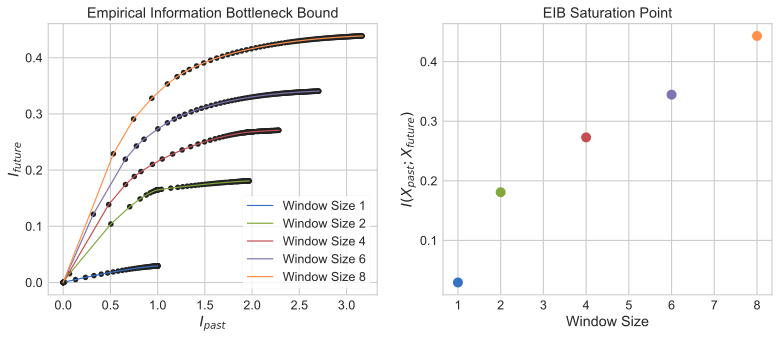

In [44]:
# Looks at the EIB for a range of different stimulus window sizes
import time
start = time.time()
window_sizes = [1,2,4,6,8]
def plot_hull(i_p, i_f, window_size):
    points = np.stack([i_p,i_f],axis=1)
    hull = np.array(convex_hull(points))
    
    #Plot the points and the hull
    
    plot(i_p,i_f,'ok')
    plot(hull[0:-1,0],hull[0:-1,1],label='Window Size %d' % int(window_size))
    xlabel('$I_{past}$')
    ylabel('$I_{future}$')
    title('Empirical Information Bottleneck Bound')
    legend()
    return hull

def printPlots(window_sizes):
    mis = []
    figure(1,(13,5))
    subplot(1,2,1)
    IPs = []
    IFs = []
    for window in window_sizes:
        Fpast_adjusted = get_new_features_sliding(np.array(d['X']), window)
        Ffuture_adjusted = np.array(d['Z'])[window:]
        i_p,i_f,beta,mi,hx,hy = eb(Fpast_adjusted,Ffuture_adjusted,numbeta=100,maxbeta=100)
        IPs.append([i_p])
        IFs.append([i_f])
        plot_hull(i_p,i_f,window)
        mis.append(mi)
        print("Window Size "+str(window))
        print(time.time()-start)

    subplot(1,2,2)
    for i in range(len(mis)):
        plot(window_sizes[i],mis[i],'o',markersize=10)
    xlabel('Window Size')
    ylabel('$I(X_{past};X_{future})$')
    title('EIB Saturation Point')


    savefig("New_EIBs.pdf")
    savefig("New_EIBs.png",dpi=150)

printPlots(window_sizes)    

### 5) Daw 2 setp task

First, try to calculate the bound for model based and model free agents performing the Daw 2-step task. Seems as though model free agents are actually more complex....do they fall farther from the bound?

In [2]:
# Load Daw 2-step simulations
daw_data = np.load('DAW_DATA_DICT_2_sims.npy').item()

# Helper functions

def trial_label(x):
    """
    turns the feature into a string of all of the features in it
    so that we can find unique combinations
    of the following variables:
        R1 = first choice (1 or 2)
        R2 = second choice (1 or 2)
        RW = reward (0 or 1)
        S2 = second state (1 or 2)
        R1*/best_R1 = first choice that would have led to greatest pr(reward)
    """
    as_strings = [num.astype(str) for num in x]
    return "".join(as_strings)




def make_features(trials_data):
    """
    Data is input in the form:
        [trials x n_features]
    
    Data is turned into the form:
        [nTrials X index ]
    where index is a unique ID from corresponding to a unique
    combination of features
    """
    labeled_data = np.apply_along_axis(trial_label, 0, trials_data)
    combos = np.unique(labeled_data)
    string_to_index = dict(zip(combos, np.arange(len(combos))))
    map_to_index = np.vectorize(lambda x: string_to_index[x])
    mapped_data = map_to_index(labeled_data)
    return mapped_data

In [85]:
model_free = daw_data[0.0]
model_based = daw_data[1.0]

MF_W = np.array(['0.0']*10000)
MF_R1 = model_free['R1'][0,]-1
MF_S2 = model_free['S2'][0,]-1
MF_R2 = model_free['R2'][0,]-1
MF_Rw = model_free['Rw'][0,]

MB_W = np.array(['1.0']*10000)
MB_R1 = model_based['R1'][0,]-1
MB_S2 = model_based['S2'][0,]-1
MB_R2 = model_based['R2'][0,]-1
MB_Rw = model_based['Rw'][0,]

aux_base = 2**np.arange(3)
MF_feat= np.array([np.dot(np.array([MF_S2[x],MF_R2[x],MF_Rw[x]]),aux_base) for x in range(len(MF_R1))])
MB_feat= np.array([np.dot(np.array([MB_S2[x],MB_R2[x],MB_Rw[x]]),aux_base) for x in range(len(MB_R1))])


MF_R1_now = MF_R1[1:]
MF_feat_past = MF_feat[:-1]

MB_R1_now = MB_R1[1:]
MB_feat_past = MB_feat[:-1]

MF_Pr_R1_F = {}
MF_Var_R1_F = {}
MF_var = []

MB_Pr_R1_F = {}
MB_Var_R1_F = {}
MB_var = []
for r1 in np.unique(MF_R1_now):
    MF_Pr_R1_F[r1] = {}
    MF_Var_R1_F[r1] = {}
    MB_Pr_R1_F[r1] = {}
    MB_Var_R1_F[r1] = {}
    for f in np.unique(feat):
        MF_Pr_R1_F_p = sum((MF_R1_now == r1)*(MF_feat_past == f))/(sum((MF_R1_now == 0)*(MF_feat_past == f))+sum((MF_R1_now == 1)*(MF_feat_past == f)))
        MF_Pr_R1_F[r1][f] = MF_Pr_R1_F_p
        MF_Var_R1_F[r1][f] = MF_Pr_R1_F_p*(1-MF_Pr_R1_F_p)
        MF_var.append(MF_Pr_R1_F_p*(1-MF_Pr_R1_F_p))
        
        MB_Pr_R1_F_p = sum((MB_R1_now == r1)*(MB_feat_past == f))/(sum((MB_R1_now == 0)*(MB_feat_past == f))+sum((MB_R1_now == 1)*(MB_feat_past == f)))
        MB_Pr_R1_F[r1][f] = MB_Pr_R1_F_p
        MB_Var_R1_F[r1][f] = MB_Pr_R1_F_p*(1-MB_Pr_R1_F_p)
        MB_var.append(MB_Pr_R1_F_p*(1-MB_Pr_R1_F_p))
        



In [91]:
print(sum(MF_var))
print(sum(MB_var))

3.886077068311537
3.827430869607741


In [58]:
# Here we're computing the EIB for:
# what the feature array from the last trial (Fpast) tells you about the current trial (Ffuture)
model_based = daw_data[0.0]
#keys = ['S2', 'R1', 'R2', 'Rw', 'best_R1']
keys = ['R1','Rw']
mb_trials = np.vstack([model_based[key] for key in keys]) 
mb_features = make_features(mb_trials)

Fpast = mb_features[:-1]
Ffuture = mb_features[1:]

mi0 = mutual_inf(Fpast,Ffuture)
# Compute the EIB - takes a few minutes to run with 3000 numbeta
# computing F0 --> F1
start = time.time()
i_p_emp,i_f_emp,beta,mi1,hx,hy = eb(Fpast,Ffuture,numbeta=50,maxbeta=50)
print('Time to compute bound')
print(time.time()-start)

/Users/alsfilip/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.


Time to compute bound
66.62011289596558


Text(0.5,1,'Empirical Information Bottleneck Bound')

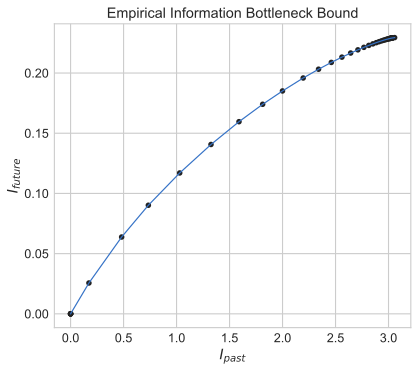

In [54]:
points = np.stack([i_p_emp,i_f_emp],axis=1)
hull = np.array(convex_hull(points))
    
#Plot the points and the hull
    
plot(i_p_emp,i_f_emp,'ok')
plot(hull[0:-1,0],hull[0:-1,1])
xlabel('$I_{past}$')
ylabel('$I_{future}$')
title('Empirical Information Bottleneck Bound')

In [195]:
import multiprocessing as mp

def daw_eib(daw_data,number,output):
    data = daw_data[number]
    keys = ['R1','Rw','R2','best_R1']
    #keys = ['R1','R2','Rw','S2','best_R1']
    m_trials = np.vstack([data[key] for key in keys]) 
    m_features = make_features(m_trials)    
    Fpast = m_features[:-1]
    Ffuture = m_features[1:]
    mi0 = mutual_inf(Fpast,Ffuture)
    i_p_emp,i_f_emp,beta,mi1,hx,hy = eb(Fpast,Ffuture,numbeta=100,maxbeta=50,iterations=30)
    output.put([i_p_emp,i_f_emp])

start = time.time()
output = mp.Queue()
ws = [0.0,1.0]
processes = [mp.Process(target=daw_eib, args=(daw_data, x, output)) for x in ws]
# Run processes
for p in processes:
    p.start()

# Exit the completed processes
for p in processes:
    p.join()

# Get process results from the output queue
results = [output.get() for p in processes]

print('Time to compute bound')
print(time.time()-start)
print("Results")
np.save('./MBMF_bounds.npy',results)

/Users/alsfilip/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/alsfilip/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.


Time to compute bound
11831.641150951385
Results


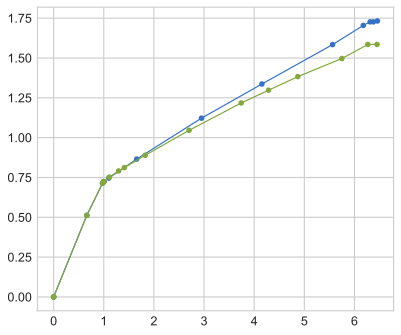

In [200]:
for i in [0,1]:
    i_s = results[i]
    points = np.stack([i_s[0],i_s[1]],axis=1)
    plot(points[:,0],points[:,1],'-o')

In [170]:
results = np.load('./MBMF_bounds.npy')
for i in range(len(results)):
    i_s = results[i]
    points = np.stack([i_s[0],i_s[1]],axis=1)
    hull = np.array(convex_hull(points))
    plot(i_s[0],i_s[1],'ok')
    plot(hull[0:-1,0],hull[0:-1,1],label="W = %f"%ws[i])
    xlabel('$I_{past}$')
    ylabel('$I_{future}$')
    title('Empirical Information Bottleneck Bound')
    legend()

TypeError: only integer scalar arrays can be converted to a scalar index

In [168]:
results[1][1]

array([2.66453526e-15, 1.57215291e+00])

In [209]:
number = 0.0
data = daw_data[number]
keys = ['R1','Rw','R2','S2','best_R1']
#keys = ['R1','R2','Rw','S2','best_R1']
m_trials = np.vstack([data[key] for key in keys]) 
m_features = make_features(m_trials)    
Fpast = m_features[:-2]
Ffuture = m_features[1:]

In [210]:
unique(m_features)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [211]:
keys_resp = ['R1']
#keys = ['R1','R2','Rw','S2','best_R1']
m_trials_resp = np.vstack([data[key] for key in keys]) 
m_features_resp = make_features(m_trials_resp)
r1 = m_features_resp[2:]

In [214]:
mutual_inf(Fpast,r1)

/Users/alsfilip/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.


4.2167470271111895